## Week 16 Homework

### 1.	Perform combined over and undersampling on the diabetes dataset (use SMOTEENN). Explain how combined sampling works.


In [1]:
# importing libraries
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold, train_test_split, StratifiedKFold

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier 
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, plot_confusion_matrix, roc_curve, RocCurveDisplay 

from sklearn.datasets import make_classification  
from sklearn.neighbors import KNeighborsClassifier  

from sklearn import metrics

from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.metrics import auc


# Read in the diabetes data, create dataframe and print the head
diabetes_df = pd.read_csv("../../in_class/in_class_assignments/diabetes.csv")
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
diabetes_df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [5]:
#Split the Features (X) and Target (y)
X=diabetes_df.drop('Outcome',axis=1)
y=diabetes_df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#show number of each class before resampling
y_train.value_counts()

0    350
1    187
Name: Outcome, dtype: int64

In [6]:
#Standardize
sc = StandardScaler()
X_train_scaler = sc.fit_transform(X_train)
X_test_scaler = sc.fit_transform(X_test)

In [7]:
##Using SMOTE-ENN to balance the data
#Define model
model=AdaBoostClassifier()
sme = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=42)
X_res, y_res = sme.fit_resample(X_train_scaler, y_train)

#Define pipeline
pipeline=Pipeline(steps=[('r', sme), ('m', model)])

#Define evaluation procedure  
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(pipeline, X_res, y_res, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

Mean Accuracy: 0.9241
Mean Precision: 0.9291
Mean Recall: 0.9231


In [8]:
#number in each class after resampling
y_res.value_counts()

1    211
0    187
Name: Outcome, dtype: int64

Combined sampling is used to balance the data. Once the class distributions are more balanced, the suite of standard machine learning classification algorithms can be fit successfully on the transformed datasets. Oversampling will duplicate or create synthetic examples in the minority class. Undersampling deletes/removes examples from the majority class. Combining them together means some examples get added to the minority class while some get removed from the majority class.


### 2.	Perform logistic regression with the new data from question 1. 
a.	Comment on the performance of combined sampling vs the other approaches we have used for the diabetes dataset.


In [9]:
model = LogisticRegression(random_state=42)
model.fit(X_res,y_res)

LogisticRegression(random_state=42)

In [10]:
y_pred = model.predict(X_test_scaler)


Previously oversampling gave us 0.69 recall, undersampling gave us 0.64, and Decision Tree Classifier gave us 0.59. Using SMOTEENN has increased recall significantly, as seen below.

In [11]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.71      0.79       150
           1       0.61      0.81      0.69        81

    accuracy                           0.75       231
   macro avg       0.74      0.76      0.74       231
weighted avg       0.78      0.75      0.75       231



### 3.	Create an ROC Curve for the model https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html and calculate the AUC. 
a.	BRIEFLY explain what the ROC Curve shows and what the resulting AUC means. 



In [12]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [13]:
model = RandomForestClassifier()  
model.fit(X_res,y_res) # resampled data from #1 above
y_pred = model.predict(X_test_scaler)

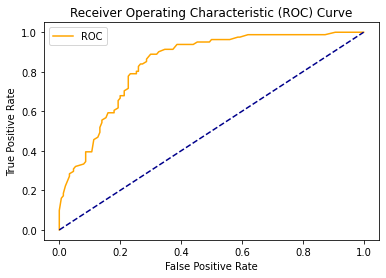

In [14]:
#use model to predict probability that given y value is 1
probs = model.predict_proba(X_test_scaler)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test, probs) 
plot_roc_cur(fper, tper)

In [15]:
#calculate AUC of model
auc = metrics.roc_auc_score(y_test,probs)

#print AUC score
print(auc)

0.8406172839506173


#### What does the ROC curve show?
The ROC curve shows the connection/trade-off between sensitivity and specificity for every possible cut-off for a test or a combination of tests. 

#### What does the resulting AUC mean?

AUC stands for “area under curve.” The closer the AUC is to 1, the better the model. The AUC is 0.84, which is high. 

Given the high AUC score, this model would be considered good at classifying observations into the correct classes.

Basically, there is 84% chance the model would be able to segregate them or rank order them correctly i.e positive point has a higher prediction probability than the negative class. 

### 4.	What is outlier detection? Why is it useful? What methods can you use for outlier detection?


#### Outlier detection  - what is it?

Outlier detection is the process of detecting outliers (a data point that is far away from the average) with the possibility of removing or resolving them to prevent any potential skewing. Outlier detection is one of the most important processes taken to create good, reliable data. Outliers are extreme data points that are beyond the expected norms for their type. This can be a whole data set that is confounding, or extremities of a certain data set. These outliers can indicate fraud or some other anomaly you are trying to detect, but they can also be measurement errors, experimental problems, or a novel, one-off blip. Basically, it refers to a data point or set of data points that diverges dramatically from expected samples and patterns.

#### Why is it useful?

Outlier detection is useful (and needed) to prevent any potential skewing in your data. Otherwise the data can hamper the model specifications or generate incorrect information.

#### What methods can you use for outlier detection?

##### Numeric outlier 
Outliers are calculated by dividing them into three quartiles. The range limits are then set as upper and lower whiskers of a box plot. Then, the data that is outside those ranges can be removed.

##### Z-score
This parametric technique indicates how many standard deviations a certain point of data is from the sample’s mean. This assumes a gaussian distribution (a normal, bell-shaped curve). The z-score of data points are then calculated, placed on the bell curve, and then using heuristics (rule of thumb) a cut-off point for thresholds of standard deviation can be decided. Then, the data points that lie beyond that standard deviation can be classified as outliers and removed from the equation.The Z-score is a simple, powerful way to remove outliers, but it is only useful with medium to small data sets. It can’t be used for nonparametric data.

##### DBSCAN
This is Density Based Spatial Clustering of Applications with Noise, which is basically a graphical representation showing density of data. DBSCAN groups data into core points, border points, and outliers. Core points are main data groups, border points have enough density to be considered part of the data group, and outliers are in no cluster at all, and can be disregarded from data. DBSCAN is great across three or more dimensions, and it is very intuitive, making visualization easy. 

##### Isolation forest
This method is effective for finding novelties and outliers. It uses binary decision trees which are constructed using randomly selected features and a random split value. The forest trees then form a tree forest, which is averaged out. Then, outlier scores can be calculated, giving each node, or data point, a score from 0 to 1, 0 being normal and 1 being more of an outlier. Isolation forests don’t require scaling and they are effective when you can’t assume value distributions. It has very few parameters, making it robust and simple to optimize. However, data visualization is complex and it can be a long, expensive process.

### 5. Perform a linear SVM to predict credit approval (last column) using this dataset: https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29 . Make sure you look at the accompanying document that describes the data in the dat file. You will need to either convert this data to another file type or import the dat file to python.
You can use this code, but otherwise you follow standard practices we have already used many times:

from sklearn.svm import SVC classifier = SVC(kernel='linear')

a. How did the SVM model perform?

The SVM model performed very well - recall of .91.


In [16]:
df = pd.read_csv("australian.dat", sep=" ", header=None, names=['A1','A2','A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15'])

In [17]:
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      690 non-null    int64  
 1   A2      690 non-null    float64
 2   A3      690 non-null    float64
 3   A4      690 non-null    int64  
 4   A5      690 non-null    int64  
 5   A6      690 non-null    int64  
 6   A7      690 non-null    float64
 7   A8      690 non-null    int64  
 8   A9      690 non-null    int64  
 9   A10     690 non-null    int64  
 10  A11     690 non-null    int64  
 11  A12     690 non-null    int64  
 12  A13     690 non-null    int64  
 13  A14     690 non-null    int64  
 14  A15     690 non-null    int64  
dtypes: float64(3), int64(12)
memory usage: 81.0 KB


In [19]:
df['A15'].value_counts() # this will be the target column

0    383
1    307
Name: A15, dtype: int64

In [21]:
X=df.drop('A15',axis=1)
y=df['A15'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Standardize
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

In [22]:
classifier = SVC(kernel='linear')
classifier.fit(X_train_sc,y_train)

SVC(kernel='linear')

In [23]:
y_pred = classifier.predict(X_test_sc)

In [24]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       126
           1       0.76      0.91      0.83        81

    accuracy                           0.85       207
   macro avg       0.85      0.86      0.85       207
weighted avg       0.87      0.85      0.85       207



### 6.	What kinds of jobs in data are you most interested in? Do some research on what is out there. Write about your thoughts in under 400 words. 

In the past, I have had a variety of experience with programming – from COBOL to CICS and ADS/O using IDMS and DB2. After mastering those, I began supporting a C++ written application, making changes to the code, testing my changes as well as doing peer reviews of other developer’s code. In addition, I used PL/SQL to find and fix data causing issues with the overall application. With my background in technology, I looked at the differences between Data Analyst, Data Engineer and Data Scientist. Based on my strong technical background, I'm leaning toward Data Engineer. I have advanced programming knowledge (prior experience), have an in-depth knowledge of SQL/databases, and understand scripting. I am getting better at data visualization - previous work experience resulted in reports or extracts, not really pictures/plots/graphs. I love programming – figuring out how to make it work and fixing it when it doesn’t. It is what I went to college for and something I have been missing in recent years. I don’t have the math background currently, even though math has been a passion of mine, to pursue a Data Scientist position.

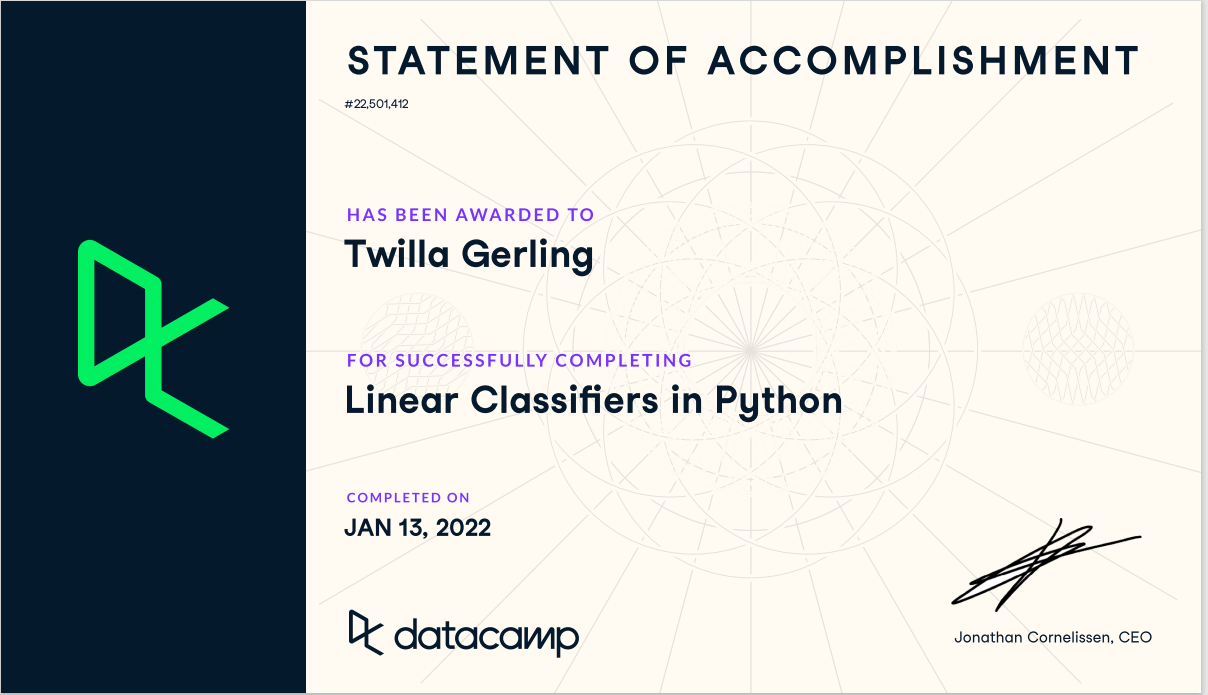

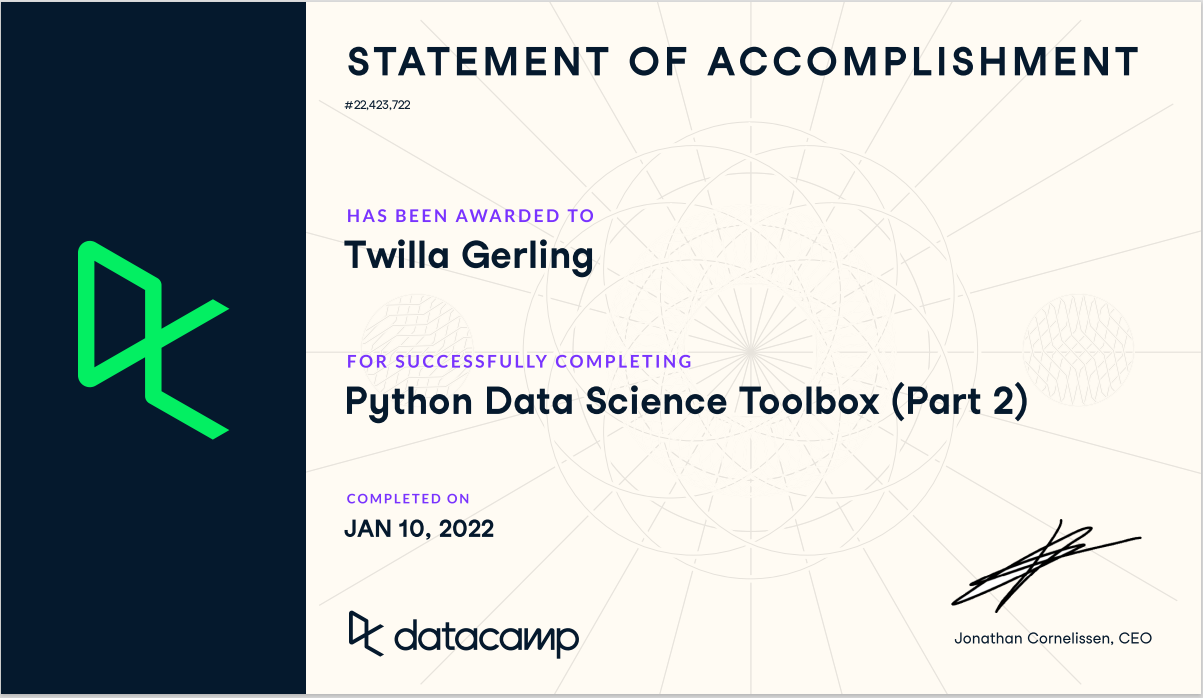